In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime
# ------------------------------------------------------
date = datetime.now().date()
# ------------------------------------------------------
m, y = date.month, date.year
# ------------------------------------------------------
min_date = date.replace(year= y-1, month = m, day = 1)
min_date_2 = date.replace(year= y-2, month = m, day = 1)
max_date = date.replace( month = m-1, day = 1)
actual_date = date.replace(day = 1)
min_date, max_date, actual_date

(datetime.date(2024, 7, 1),
 datetime.date(2025, 6, 1),
 datetime.date(2025, 7, 1))

In [2]:
var= "toneladas_plan_ventas"
var2del = "toneladas_pvo"
pvo = pd.read_csv(r".\consultas\pvo.csv", engine="pyarrow")
pvo.nom_familia_asociada = pvo.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)
pvo.nom_ubicacion = pvo.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)

pvo["Base"] = "pvo"
pvo = pvo.drop(columns= ["toneladas_dim_capacidades", var2del]) #"toneladas_pvo"
print(pvo.shape)
pvo = pvo.dropna(subset = [var, "nom_articulo", "nom_ubicacion"], how="any")
print(pvo.shape)
pvo["MesAct_fact"] = False

(1453880, 13)
(157498, 13)


In [3]:
fact = pd.read_csv(r".\consultas\fact.csv", engine="pyarrow")
fact.nom_familia_asociada = fact.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)
fact.nom_ubicacion = fact.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)
fact["Base"] = "fact"
fact = fact[fact.MesAnio >= min_date_2]
fact["MesAct_fact"] = np.where( fact.MesAnio == actual_date, True, False)
fact.nom_familia_asociada = np.where(fact.nom_familia_asociada.isna(), fact.nom_articulo, fact.nom_familia_asociada) 
fact.MesAnio.nunique()

19

In [ ]:
fact.groupby("NombreGrupoEstadistico1").Toneladas_Facturadas.sum()

"""
ALAMBRON -ge3
PALANQUILLA-G1 [Solo se vede a 1SHOT]
PERFILES- ge3
SOLUCIONES-GE3
VARILLA-GE3
TODOS LOS DEMAS A NIVEL SKU
"""

NombreGrupoEstadistico1
ALAMBRON               6.197548e+05
CABLES                 6.193106e+03
INDUSTRIAL FILIALES    2.504627e+04
MALLAS Y ALAMBRES      1.072834e+06
PALANQUILLA            1.300822e+05
PERFILES               7.073273e+05
SOLUCIONES             1.525432e+05
VARILLA                1.422561e+06
Name: Toneladas_Facturadas, dtype: float64

# Analisis de articulos (SKUs)

In [ ]:
print(f"Existe un total de {fact.nom_articulo.nunique()} articulos")
print(f"Existe un total de {fact.nom_ubicacion.nunique()} puntos logisticos")
print(f"Existe un total de {fact.nom_familia_asociada.fillna(fact.nom_articulo).nunique()} Familias Asociadas")
print(f"Existe un total de {fact.NombreGrupoEstadistico3.nunique()} GE3")
fact.nom_articulo.value_counts()

Existe un total de 9715 articulos
Existe un total de 136 puntos logisticos
Existe un total de 240 Familias Asociadas
Existe un total de 270 GE3


nom_articulo
VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 R                1077
VARILLA DA- 506 G42 C1 1/2" 12.0 M P02 R                 1068
VARILLA DA- 506 G42 C1 5/8" 12.0 M P03 R                 1002
VARILLA DA- 506 G42 C1 3/4" 12.0 M P04 R                  967
VARILLA DA- 506 G42 C1 1" 12.0 M P05 R                    826
                                                         ... 
BOST P51-10B PLIER STAPLER 1/2" CRWN, 3/8" - 5/8" LEN       1
GALVANIZED WIRE NOWAX C1 9 2000 LB                          1
PLAIN ROUND BAR 615 G60 1" 20FT P11 R                       1
CHANNEL 5" X 6.7 44W/50W 60' 4.3T                           1
STANDARD BEAM 6" X 12.5 A36/A572-50 40FT 2.7T               1
Name: count, Length: 9715, dtype: int64

In [5]:
skus = fact.groupby(["nom_articulo", "NombreGrupoEstadistico3"]).agg({"Toneladas_Facturadas": ["sum", "count"], "NombreGrupo":["nunique","unique"]})
skus.columns = ["ton_sum", "ton_count", "bus_unicos", "bus"]
skus["bus"] = skus["bus"].apply(lambda x:str(set(x)))
skus[skus.bus_unicos > 1].bus.value_counts()

bus
{'ACEROS', 'ALAMBRES'}                                              396
{'USA', 'ALAMBRES'}                                                 113
{'FILIALES ALAMBRES', 'ALAMBRES'}                                    73
{'FILIALES ALAMBRES', 'ACEROS', 'ALAMBRES'}                          62
{'ACEROS', 'USA'}                                                    54
{'FILIALES ALAMBRES', 'ACEROS', 'DEACERO SOLUTIONS', 'ALAMBRES'}     40
{'FILIALES ALAMBRES', 'USA'}                                         28
{'ACEROS', 'DEACERO SOLUTIONS', 'ALAMBRES'}                          25
{'ACEROS', 'USA', 'ALAMBRES'}                                        22
{'DEACERO SOLUTIONS', 'ALAMBRES'}                                    12
{'USA', 'DEACERO SOLUTIONS'}                                         12
{'ACEROS', 'DEACERO SOLUTIONS'}                                       9
{'ALAMBRES', 'DEACERO SOLUTIONS'}                                     9
{'FILIALES ALAMBRES', 'ACEROS'}                             

In [ ]:
skus.reset_index() #----------------.groupby("NombreGrupoEstadistico3")

,nom_articulo,NombreGrupoEstadistico3,ton_sum,ton_count,bus_unicos,bus
0,"""52"""" STRETCHER BAR BOLT STYLE""",FENCE TOOLS,0.939102,15,1,{'USA'}
1,"""66"""" STRETCHER BAR BOLT STYLE""",FENCE TOOLS,0.429000,13,1,{'USA'}
2,"""BRACE PIN 1/2"""" X 10"""" HDG""",FENCE TOOLS,6.533390,18,1,{'USA'}
3,"""BRACE PIN 1/2"""" X 4"""" HDG""",FENCE TOOLS,2.218680,17,1,{'USA'}
4,"""HIGHER FLOW - ROJO VALVE 3/4""""""",FARM ACCESSORIES,0.029000,13,1,{'USA'}
...,...,...,...,...,...,...
9723,WIREMAX GALVANIZED STEEL WIRE STRAND EHS CLASS...,RETENIDAS INTERMEDIA,9.713640,3,1,{'USA'}
9724,WIREMAX GALVANIZED STEEL WIRE STRAND EHS CLASS...,RETENIDAS INTERMEDIA,29.019460,5,1,{'USA'}
9725,WIREMAX GALVANIZED STEEL WIRE STRAND EHS CLASS...,RETENIDAS INTERMEDIA,121.317700,11,1,{'USA'}
9726,"Y POST EXTENSION ADD ON 4"" POST BLACK",REJA CLASICA,1.130000,2,1,{'USA'}


In [ ]:
# Agrupamos por NombreGrupoEstadistico3 y agregamos las columnas necesarias
tab = skus.reset_index().groupby("NombreGrupoEstadistico3").agg({"nom_articulo": "nunique" , "ton_count": "sum", "ton_sum": ["sum","mean", "std"]})
tab.columns = ["sku_unicos","pedidos","ton_sum", "ton_mean", "ton_std"]
tab["cov"] = tab["ton_std"] / tab["ton_mean"]
tab["part"] = tab["ton_sum"] / tab["ton_sum"].sum()
tab = tab.sort_values("ton_sum", ascending=False)
tab["pareto"] = tab.part.cumsum()
tab.round(2).head(40)

,sku_unicos,pedidos,ton_sum,ton_mean,ton_std,cov,part,pareto
NombreGrupoEstadistico3,,,,,,,,
VARILLA 3/8,33,2459,467492.76,14166.45,43161.20,3.05,0.11,0.11
VARILLA 1/2,35,2448,362673.14,10362.09,34080.02,3.29,0.09,0.20
ALAMBRON TREFILAR ANTAAC,42,912,257759.55,6137.13,12059.06,1.96,0.06,0.26
CANALES ESTRUCTURALES,189,2938,169569.55,897.19,1767.09,1.97,0.04,0.30
ALAMBRON TREFILAR MYA,77,836,156180.28,2028.32,5064.28,2.50,0.04,0.34
VARILLA 5/8,29,1395,156008.70,5379.61,18425.22,3.43,0.04,0.38
VARILLA 1,26,1028,150553.66,5790.53,22527.37,3.89,0.04,0.42
PALANQUILLA,7,19,130082.17,18583.17,39528.10,2.13,0.03,0.45
VARILLA 3/4,29,1256,122665.92,4229.86,17197.48,4.07,0.03,0.48


In [8]:
# Agrupamos por familia y ubicacion (pl)
fam_pl = fact.groupby(["nom_articulo", "nom_ubicacion", "MesAnio"])["Toneladas_Facturadas"].sum().reset_index()
fam_pl["id"] = fam_pl.nom_articulo + "_" + fam_pl.nom_ubicacion
pvo["id"] = pvo.nom_articulo + "_" + pvo.nom_ubicacion
fam_pl.id.nunique() # 1944 combinaciones de pl & familias


21240

facturacion por mes volumen total


<Axes: xlabel='MesAnio'>

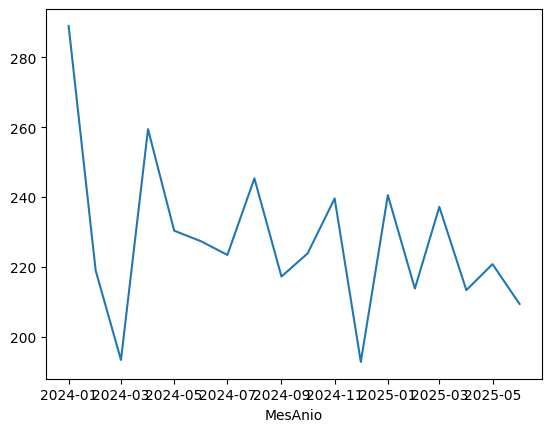

In [9]:
print("facturacion por mes volumen total")
# Facturación por familia y Ubicación
fam_pl.groupby("MesAnio").Toneladas_Facturadas.sum()[:-1].div(1000).plot()

# Analisis x SKUs PL

In [77]:
# Familia & SKU
print("Existe un total de {} pl y skus".format(fam_pl.id.nunique()))
print("Existe un total de {} articulos".format(fam_pl.nom_articulo.nunique()))
print("Existe un total de {} ubicaciones".format(fam_pl.nom_ubicacion.nunique()))

Existe un total de 21240 pl y skus
Existe un total de 9715 articulos
Existe un total de 136 ubicaciones


In [21]:
print(fam_pl.shape[0])
fam_pl_f =  fam_pl[fam_pl.Toneladas_Facturadas>0]
print(fam_pl_f.shape[0])
fam_pl_f =  fam_pl[fam_pl.Toneladas_Facturadas>0]

kpi2 = fam_pl_f.groupby("id").agg({"MesAnio":["min", "max"]})
kpi2.columns = ["fecha_inicio", "fecha_fin"]
kpis = fam_pl_f.groupby("id").agg({ "nom_articulo": "count", "Toneladas_Facturadas":"mean"}).rename(columns = {"nom_articulo": "mcc", "Toneladas_Facturadas": "ton_media"} )
kpis = kpis.merge(kpi2, left_index=True, right_index=True)
kpis["r_ton_med"] = pd.qcut(kpis.ton_media, q = 4, labels = [1,2,3,4])
kpis["r_mcc_med"] = pd.qcut(kpis.ton_media, q = 4,  labels = [1,2,3,4])
kpis.fecha_inicio = pd.to_datetime(kpis.fecha_inicio) 
kpis.fecha_fin = pd.to_datetime(kpis.fecha_fin) 
kpis["qdate"] = kpis.fecha_inicio.dt.year.mul(100) + kpis.fecha_inicio.dt.quarter
kpis["qdate"]= np.where(kpis.fecha_inicio.dt.year < 2024, kpis.fecha_inicio.dt.year.mul(100), kpis["qdate"] )
kpis["msc"] = kpis.fecha_fin.max() - kpis.fecha_fin
kpis["msc"] = kpis["msc"].dt.days.div(30).round(0)
kpis["r_msc"] = pd.cut(kpis.msc, bins = [-np.inf, 1, 2, 3, 4, 8 , 10,12, np.inf], labels = [1,2,3,4,8, 10, 12, 13] )
#kpis["Q"] =  kpis.fecha_inicio.dt.quarter

def freq(x): 
    # pandas time series
    x = x[x.Toneladas_Facturadas > 0]
    if x.shape[0]< 2 :
        return None
    else:  
        x = round(x.MesAnio.diff().mean().days / 30) 
        return x
    
base = fam_pl.reset_index().groupby(["MesAnio", "id"]).Toneladas_Facturadas.sum().reset_index()
base.MesAnio = pd.to_datetime(base.MesAnio)
base_gb = base.groupby("id")
calculo_frecuencia_media = base_gb.apply(lambda x :  freq(x))
calculo_frecuencia_media = calculo_frecuencia_media.reset_index().rename(columns = {0: "Freq"})
kpis = kpis.reset_index().merge(calculo_frecuencia_media, on = "id")
kpis["Freq"] = kpis["Freq"].fillna(24)
kpis ["r_freq"] = pd.cut(x = kpis.Freq, bins = [0, 1,2,3,6,9,12, 19,24], labels = [1,2,3,6,9,12,19, 24])

# Calculo de Trimestre que se tienen transacciones PL & FAMILIA
import re
fam_pl.MesAnio = pd.to_datetime(fam_pl.MesAnio)
fam_pl_q = fam_pl.groupby(["id", fam_pl.MesAnio.dt.quarter]).Toneladas_Facturadas.sum().reset_index().sort_values(by = ["id", "MesAnio"], ascending=[True, True])
fam_pl_q = fam_pl_q.sort_values(by = "MesAnio", ascending=False) 
fam_pl_q.MesAnio =  fam_pl_q.MesAnio.astype(str) 
fam_pl_q = fam_pl_q.groupby("id").MesAnio.unique().apply(lambda x: re.sub(r'\D', '', str(set(x)))).reset_index()
kpis = kpis.merge(fam_pl_q,on = "id", how="left").rename(columns = {"MesAnio": "Q"})
kpis["len_Q"] = kpis.Q.apply(lambda x: len(x))
kpis["Q"] = kpis.Q.astype(int)

kpis["var_mcc_4_or_less"] = np.where(kpis.mcc < 5, True, False)

display(kpis.sample(10))

print(" Analisis de Cuando Arrancan los ids 2024 -2025")
kpis = kpis.sort_values(by = "qdate")
display(pd.DataFrame(pd.crosstab(kpis.qdate, kpis.r_mcc_med, normalize=True).T.sum()).T.style.format("{:.2%}"))
pd.crosstab(kpis.qdate, kpis.r_mcc_med, margins = True).T

124059
115090


C:\Users\adojeda\AppData\Local\Temp\ipykernel_6752\2672948042.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calculo_frecuencia_media = base_gb.apply(lambda x :  freq(x))


,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less
2460,"ALAMBRE DELGADO 2.03MM (205007) 0.080"" 1074 R-...",19,10.811947,2024-01-01,2025-07-01,3,3,202401,0.0,1,1.0,1,3214,4,False
3859,"ALAMBRE NEGRO MBI .059"" 1065 Q- 200- 220KGS_IN...",2,0.523000,2024-02-01,2025-05-01,2,2,202401,2.0,2,15.0,19,12,2,True
19367,VALLA DEACERO AMARILLO 1.22M 2M_ALAMBRES MÉXICO,1,1.458000,2024-02-01,2024-02-01,2,2,202401,17.0,13,24.0,24,1,1,True
12633,"GRAPA GALV. CORRUGADA 1"" 9 25KG_CEDI VILLAHERM...",19,21.988158,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False
11895,"GALVANIZED SOLAR PIERS 6"" X 20 A992/A572-50 24...",1,0.546000,2024-09-01,2024-09-01,2,2,202403,10.0,10,24.0,24,34,2,True
19539,"VARILLA DA- 506 G42 C1 1 1/4"" 12.0 M P06 R_PAT...",13,119.443000,2024-04-01,2025-04-01,4,4,202402,3.0,3,1.0,1,3214,4,False
14706,MALLA INGENIERIA 10 30CM 8.23MM 6.35 MM 1.98M ...,1,2.328000,2024-08-01,2024-08-01,3,3,202403,11.0,12,24.0,24,3,1,True
8121,"CLAVO ALFILERILLO S/C 5/8"" 18 25KG_AN PACHUCA",1,0.025000,2025-06-01,2025-06-01,1,1,202502,1.0,1,24.0,24,2,1,True
9390,"CLAVO TOMATERO 1 1/4"" #3 25KG_ALMACEN ANSA",7,1.653571,2024-02-01,2025-04-01,2,2,202401,3.0,3,2.0,2,312,3,False
659,2 X 113 BC SC 15° 9M/BX 45 BX/SK 2505 #/SK_MID...,5,2.370381,2024-04-01,2025-06-01,3,3,202402,1.0,1,4.0,6,324,3,False


 Analisis de Cuando Arrancan los ids 2024 -2025


qdate,202401,202402,202403,202404,202501,202502,202503
0,53.76%,14.90%,9.43%,6.93%,6.88%,7.51%,0.59%


qdate,202401,202402,202403,202404,202501,202502,202503,All
r_mcc_med,,,,,,,,
1,2599,801,581,375,375,420,20,5171
2,2805,771,466,305,347,451,25,5170
3,2767,822,494,388,344,311,44,5170
4,2948,687,410,366,356,372,32,5171
All,11119,3081,1951,1434,1422,1554,121,20682


### Deacuerdo a todas las combinaciones de sku & PL 
#### Rango de venta (r_mcc_med) vs Primer registro con transacción (qdate)

* 11119 tuvieron su primer movimiento en el 2024Q1 ~53%,
* el resto tuvieron primero movimiento en 2024Q2 o posterior ~47%

Esto quiere decir que posiblemente las series de tiempo no sean de consumo recurrente, la frecuencia de recompra por lo tanto podria influir en la demanda de los productos
#### Analisis de Frecuencia de reparto
Se procedió a calcular la frecuencia media de reparto como la distancia entre meses con consumo de tonelaje mayor que 0, luego promedio.


In [38]:
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.r_mcc_med, normalize=True).T.sum()).T.style.format("{:.2%}"))
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.r_mcc_med, values= kpis.ton_media, aggfunc= "sum",  normalize=True).T.sum()).T.style.format("{:.2%}"))
pd.crosstab(kpis.r_freq, kpis.r_mcc_med, margins = True).T

r_freq,1,2,3,6,9,12,19,24
0,33.20%,16.14%,7.08%,7.81%,2.09%,0.82%,0.37%,32.50%


r_freq,1,2,3,6,9,12,19,24
0,58.77%,13.42%,4.95%,4.08%,0.92%,0.21%,0.10%,17.54%


r_freq,1,2,3,6,9,12,19,24,All
r_mcc_med,,,,,,,,,
1,1148,819,387,519,149,58,25,2066,5171
2,1681,719,360,409,111,44,18,1828,5170
3,1709,870,347,381,101,46,27,1689,5170
4,2328,930,370,306,71,21,7,1138,5171
All,6866,3338,1464,1615,432,169,77,6721,20682


El 33% de los SKUs pertenecen a una frecuencia de Reparto Mensual, 16% bimestral y 7% trimestral

esto quiere decir que menos del **50**% de las combinaciones son de frencia Mensual o bimestral. (**70% tons**)

esto quiere decir que:  
* si tomamos una ventana de tiempo de analisis de 3 meses podriamos encontrar menos del 50% de las combinaciones desagregadas (**70% tons**),
* para evitar un sesgo se recomienda tener una ventana de analisis que ajuste al 70% de las observacionees (1Y) debido a que el otro 32% son pedidos únicos.

si el **32%** de los skus son pedidos unicos por PL, generarian alertas automáticas (6.7k) **~17%** del volumen total....

In [ ]:
kpis = kpis.sort_values(by = "len_Q", ascending=False)
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.len_Q, normalize=True).sum()).T.style.format("{:.2%}"))
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.len_Q, normalize=True)).style.format("{:.2%}"))
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.len_Q, values= kpis.ton_media, aggfunc= "sum", normalize=True)).style.format("{:.2%}"))
pd.crosstab(kpis.r_freq, kpis.len_Q, margins = True)

len_Q,1,2,3,4
0,36.43%,20.07%,13.39%,30.11%


len_Q,1,2,3,4
r_freq,,,,
1,5.68%,4.94%,2.36%,20.22%
2,0.71%,3.48%,4.54%,7.42%
3,0.00%,2.31%,3.03%,1.75%
6,0.13%,4.10%,2.88%,0.71%
9,0.04%,1.66%,0.37%,0.01%
12,0.38%,0.42%,0.01%,0.01%
19,0.12%,0.25%,0.00%,0.00%
24,29.37%,2.92%,0.20%,0.00%


len_Q,1,2,3,4
r_freq,,,,
1,3.70%,6.17%,7.49%,41.41%
2,0.23%,3.41%,3.30%,6.48%
3,0.00%,1.08%,1.75%,2.12%
6,0.06%,1.58%,2.05%,0.39%
9,0.04%,0.65%,0.22%,0.01%
12,0.09%,0.08%,0.05%,0.00%
19,0.02%,0.08%,0.00%,0.00%
24,15.25%,1.93%,0.36%,0.00%


len_Q,1,2,3,4,All
r_freq,,,,,
1,1174,1021,489,4182,6866
2,147,719,938,1534,3338
3,0,477,626,361,1464
6,27,847,595,146,1615
9,9,344,76,3,432
12,78,87,2,2,169
19,24,52,1,0,77
24,6075,604,42,0,6721
All,7534,4151,2769,6228,20682


El **30%** de las combinaciones se compran en los 4 trimestreas , de ellas solo el **20%* del total corresponde a pedidos mensuales y **7.5%** bimestrales.

esto quiere decir que solo se pueden analizar el **20%** de las combinaciones lo que equivale al **41.4%** del volumen total.

In [24]:
pd.crosstab(index = kpis.r_mcc_med, columns = kpis.qdate , values = kpis.ton_media, aggfunc= "median").fillna(0).round(2)

qdate,202401,202402,202403,202404,202501,202502,202503
r_mcc_med,,,,,,,
1,0.08,0.04,0.05,0.04,0.04,0.05,0.04
2,0.95,1.01,0.99,0.98,0.98,1.02,0.90
3,4.61,4.41,4.55,4.40,5.31,4.47,6.77
4,34.07,27.75,29.36,33.96,30.54,32.05,23.17


listado de indicadores: 
* ton_media: toneladas promedio por mes (se excluyen ceros y valores negativos)
* msc: meses sin compra
* Freq : Frecuencia de Entrega
* Q : Trimestre con compra ej, 1234 : Q1,Q2,Q3,Q4...
* len_Q : cantidad de trimestres con compra
* var_mcc_4_or_less: con almenos 4 meses con compra (facturacion )

In [48]:
kpis[kpis.mcc==1]

,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less,cluster
5034,"ANGLE 2"" X 2"" X 1/4"" A572-50 40' 4.0T_B. USA V...",1,12.154000,2024-01-01,2024-01-01,4,4,202401,18.0,13,24.0,24,312,3,True,8
10000,DADO CHUCK P/CLIPS CAL 11_CEDI CULIACAN,1,0.001000,2025-04-01,2025-04-01,1,1,202502,3.0,3,24.0,24,312,3,True,9
6118,BARRA CORRUGADA DEACERO 615 G60 C2 8.0MM 9.0M ...,1,1130.000000,2025-06-01,2025-06-01,4,4,202502,1.0,1,24.0,24,312,3,True,4
20479,WIRE ROD 9.5MM 1006 2.0T_CHICAGO DC,1,40.164000,2024-12-01,2024-12-01,4,4,202404,7.0,8,24.0,24,214,3,True,9
4087,"ALAMBRE PULIDO .0280"" 1004 60-80KG_ALAMBRES MÉ...",1,0.158000,2024-03-01,2024-03-01,1,1,202401,16.0,13,24.0,24,312,3,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,"CHANNEL 8"" X 11.5 44W/50W 50' 4.0T_MACROHUB LA...",1,4.173050,2025-07-01,2025-07-01,3,3,202503,0.0,1,24.0,24,3,1,True,9
7904,"CHANNEL 8"" X 11.5 44W/50W 60' 4.0T_MACROHUB LA...",1,11.267220,2025-07-01,2025-07-01,3,3,202503,0.0,1,24.0,24,3,1,True,9
3917,"ALAMBRE NEGRO MBII .236"" 1080M A- 600-900KG_IN...",1,1.000000,2025-07-01,2025-07-01,2,2,202503,0.0,1,24.0,24,3,1,True,9
26,(L) STPL 1L X 1/4CR 18GA 5M/BX 10BX/CS_MID CO...,1,0.018733,2024-03-01,2024-03-01,1,1,202401,16.0,13,24.0,24,1,1,True,8


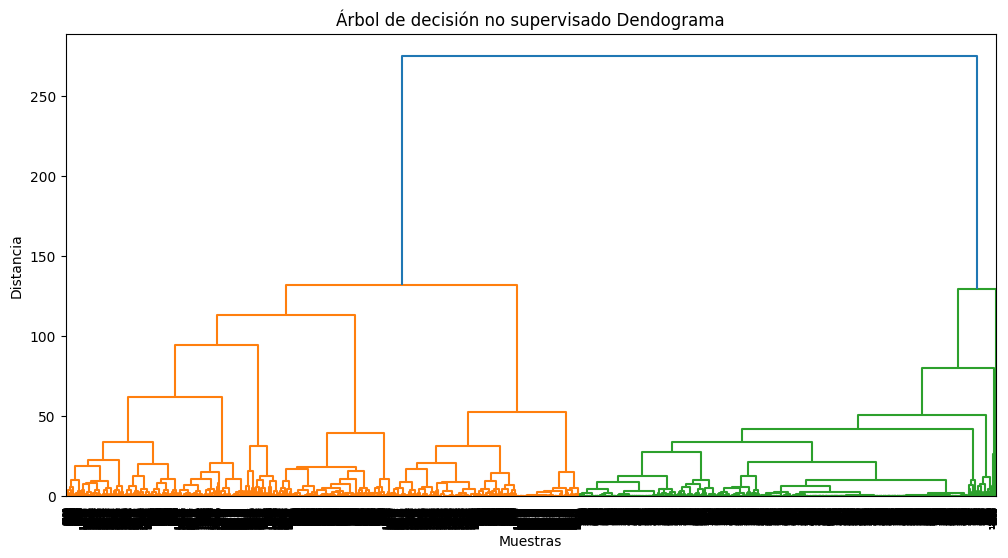

In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

columnas = ['ton_media', 'msc', 'Freq', 'Q', 'len_Q', "var_mcc_4_or_less"]
kpis_f = kpis[kpis.mcc>1].copy()
df_numerico = kpis_f[columnas]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerico)

# Clustering jerárquico
linked = linkage(X_scaled, method='ward')

# Dendrograma
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Árbol de decisión no supervisado Dendograma')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

In [53]:
from scipy.cluster.hierarchy import fcluster

from scipy.stats import f_oneway

f_c = fcluster(linked, t=50, criterion='distance')
kpis_f['cluster'] = f_c
X_scaled_df =pd.DataFrame(X_scaled, columns=columnas)
X_scaled_df['cluster'] = f_c

print(kpis['cluster'].value_counts())


anova_results = {}

for var in columnas:
    groups = [group[var].values for name, group in X_scaled_df.groupby('cluster')]
    f_stat, p_val = f_oneway(*groups)
    anova_results[var] = {'F-statistic': f_stat, 'p-value': p_val}

# Convertir resultados a DataFrame ordenado por F-statistic
anova_df = pd.DataFrame(anova_results).T.sort_values(by='F-statistic', ascending=False)
anova_df



cluster
5    6196
8    3663
6    3288
9    3047
7    2777
3    1656
4      52
1       2
2       1
Name: count, dtype: int64


,F-statistic,p-value
var_mcc_4_or_less,478185.488149,0.0
Q,217798.257119,0.0
len_Q,13850.245119,0.0
ton_media,7855.882544,0.0
Freq,5980.810881,0.0
msc,4681.268141,0.0


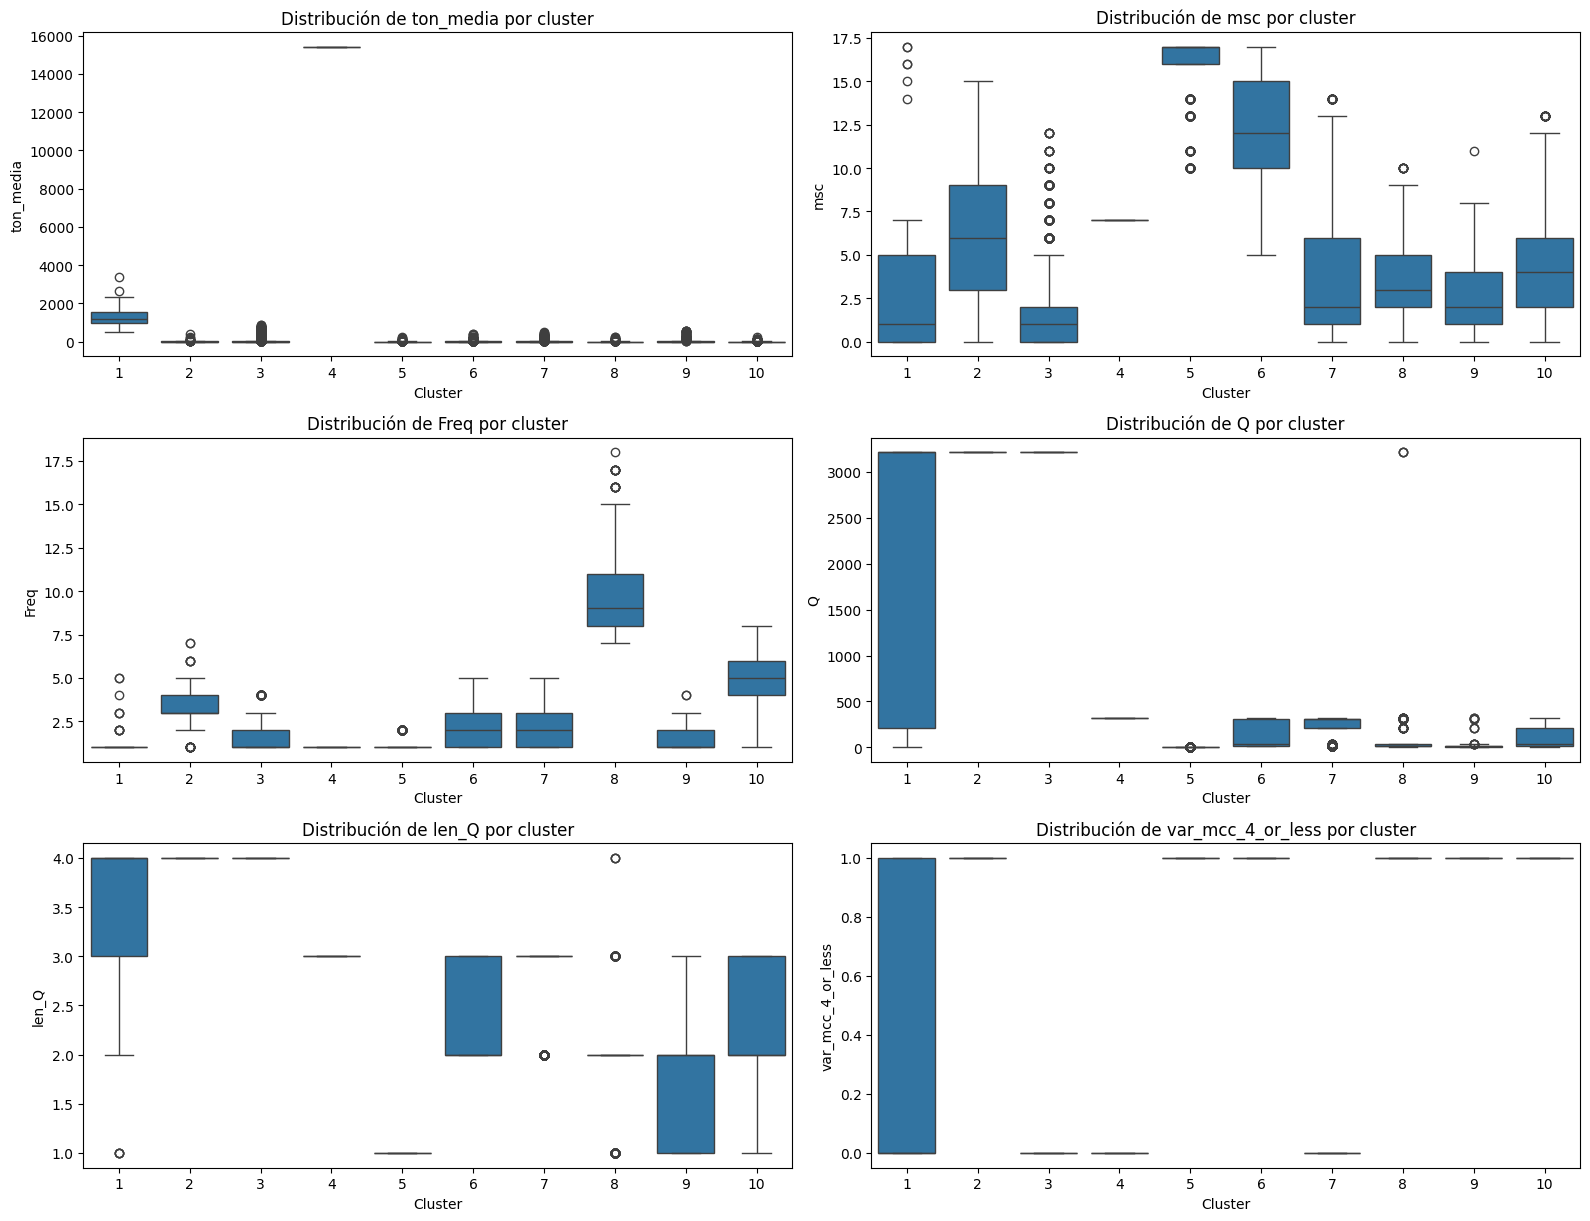

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráficos de caja para cada variable por cluster
plt.figure(figsize=(16, 20))
for i, var in enumerate(columnas, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x='cluster', y=var, data=kpis_f)
    plt.title(f'Distribución de {var} por cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)

plt.tight_layout()
plt.show()



In [56]:
kpis_f.groupby("cluster").agg({i:["count","median", "mean"]  for i in columnas[:-3]}).sort_values(by = ("ton_media", "mean"), ascending=False).round(2)

ton_media                       msc                Freq              
            count    median      mean count median   mean count median   mean
cluster                                                                      
4               1  15421.95  15421.95     1    7.0   7.00     1    1.0   1.00
1              53   1198.44   1324.02    53    1.0   3.06    53    1.0   1.42
3            5954      3.62     29.86  5954    1.0   1.54  5954    1.0   1.37
9             998      4.17     28.02   998    2.0   2.73   998    1.0   1.34
7            1671      2.90     18.68  1671    2.0   3.95  1671    2.0   2.14
2             238      3.10     14.64   238    6.0   5.99   238    3.0   3.33
6            1908      2.91     13.89  1908   12.0  12.30  1908    2.0   2.07
8             515      1.20      9.31   515    3.0   3.57   515    9.0  10.01
5             949      1.11      7.86   949   17.0  15.75   949    1.0   1.10
10           1674      1.44      7.68  1674    4.0   4.54  1674    5.0   4.59

In [58]:
kpis_f[kpis_f.cluster.isin([1,4])].sort_values(by = "ton_media", ascending=False)

,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less,cluster
15598,PALANQUILLA 130 1044 MITTAL 13.0 M_ACERÍA CELAYA,7,15421.952857,2024-06-01,2024-12-01,4,4,202402,7.0,8,1.0,1,324,3,False,4
19723,"VARILLA DA- 506 G42 C1 3/8"" 12.0 M P122 R_ACER...",19,3398.522208,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False,1
19613,"VARILLA DA- 506 G42 C1 1/2"" 12.0 M P02 R_ACERÍ...",19,2646.256699,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False,1
19624,"VARILLA DA- 506 G42 C1 1/2"" 12.0 M P02 R_CEDI ...",19,2343.166565,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False,1
19971,VARILLA EN ROLLO DEACERO 615 G60 C2 5.7MM 1.4T...,2,2126.228500,2025-01-01,2025-06-01,4,4,202501,1.0,1,5.0,6,312,3,True,1
4426,ALAMBRON 5.5MM 1006 SAE 2.5T_ACERÍA CELAYA,18,2028.357776,2024-01-01,2025-06-01,4,4,202401,1.0,1,1.0,1,3214,4,False,1
19692,"VARILLA DA- 506 G42 C1 3/8"" 12.0 M P122 D_ACER...",19,2002.929321,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False,1
19717,"VARILLA DA- 506 G42 C1 3/8"" 12.0 M P122 D_PATI...",19,1981.633105,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False,1
19564,"VARILLA DA- 506 G42 C1 1"" 12.0 M P05 R_CEDI VI...",13,1749.001002,2024-01-01,2025-06-01,4,4,202401,1.0,1,1.0,1,3214,4,False,1
19562,"VARILLA DA- 506 G42 C1 1"" 12.0 M P05 R_CEDI VI...",19,1732.205483,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,3214,4,False,1


In [59]:
cluster2_pvo = pvo[pvo.id.isin(kpis_f[kpis_f.cluster.isin([1,4])].id)]
cluster2_pvo["MesAnio"] = pd.to_datetime(cluster2_pvo.MesAnio)
cluster2_pvo= cluster2_pvo.groupby(["MesAnio", "id"]).toneladas_plan_ventas.sum().unstack(-1)
cluster2_pvo["tipo"] = "pvo"
cluster2_pvo

C:\Users\adojeda\AppData\Local\Temp\ipykernel_6752\3520651265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster2_pvo["MesAnio"] = pd.to_datetime(cluster2_pvo.MesAnio)


id,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",ALAMBRON 5.5MM 1004 2.9T_ACERÍA CELAYA,ALAMBRON 5.5MM 1004 2.9T_ACERÍA SALTILLO,ALAMBRON 5.5MM 1004 M 2.5T_ACERÍA CELAYA,ALAMBRON 5.5MM 1006 SAE 2.5T_ACERÍA CELAYA,ALAMBRON 5.5MM BC COLLIS 1.4T_ACERÍA CELAYA,ALAMBRON 6.5MM 1006 VDE_ACERÍA SALTILLO,"BARRA CORRUGADA DEACERO 615 G60 C2 3/8"" 9.0M P23 R_PUERTO MAZATLAN","REBAR DA- 706 G60 C2 1/2"" 20FT P02 R_B. USA VTS DIR","REBAR DA- 706 G60 C2 3/8"" 20FT P08 R_B. USA VTS DIR",...,"VARILLA DA- 615 G40 C6 1/2"" 6.0 M P68 R_PUERTO MAZATLAN","VARILLA DA- 615 G40 C6 3/8"" 6.0 M P66 R_PUERTO MAZATLAN",VARILLA DA- 615 G40 C6 8.0MM 6.0 M P126 R_PUERTO MAZATLAN,VARILLA EN ROLLO DEACERO 615 G60 C2 5.7MM 1.4T C_PUERTO MAZATLAN,VARILLA G42_PLANTA INGETEK,VARILLA G42_PLANTA INGETEK TLN,WIRE ROD 5.5MM 1006 2.0T_B. USA VTS DIR,WIRE ROD 5.5MM 1006 2.0T_CEDI CINCINNATI,WIRE ROD 5.5MM 1006 2.0T_WEST MEMPHIS DC.,tipo
MesAnio,,,,,,,,,,,,,,,,,,,,,
2025-07-01,1429.628530,1878.050230,1839.381020,571.866450,2248.06114,1591.800570,1563.365760,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,1581.538020,834.319490,167.661500,0.0,0.0,pvo
2025-08-01,1492.748639,2047.064999,2163.548145,571.866454,2234.54104,1591.800571,1857.428673,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,1536.491144,1076.404578,167.661497,0.0,0.0,pvo
2025-09-01,1403.771817,2047.064999,2163.548145,571.866454,2264.54104,1591.800571,1843.224590,NaN,0.0,0.0,...,1338.6976,2048.782754,156.233997,NaN,1783.990435,1020.033589,167.661497,0.0,0.0,pvo
2025-10-01,1394.572150,1751.205290,2150.148310,1007.266950,2258.99303,1549.746370,1843.847740,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1749.407500,980.506310,167.661500,0.0,0.0,pvo
2025-11-01,1413.018180,1751.205290,2148.890150,1007.266950,2232.24629,1549.746370,1842.795410,NaN,NaN,NaN,...,1338.6976,2048.782750,156.234000,NaN,1704.428210,1002.261390,167.661500,0.0,NaN,pvo
2025-12-01,1426.287910,1432.482460,1773.424510,559.592750,1900.34953,1271.586770,1537.298640,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1621.285370,953.370600,167.661500,NaN,NaN,pvo


In [75]:
cluster2_venta = fam_pl[fam_pl.id.isin(kpis_f[kpis_f.cluster.isin([1,4])].id)]
cluster2_venta = cluster2_venta.groupby(["MesAnio", "id"]).Toneladas_Facturadas.sum().unstack(-1).fillna(0)
cluster2_venta["tipo"] = "venta"

cluster_2 = pd.concat([cluster2_venta, cluster2_pvo])
cluster_2
cluster_2 = cluster_2[~((cluster_2.index == "2025-07-01") &	(cluster_2.tipo == "venta"))]
cluster_2

id,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",ALAMBRON 5.5MM 1004 2.9T_ACERÍA CELAYA,ALAMBRON 5.5MM 1004 2.9T_ACERÍA SALTILLO,ALAMBRON 5.5MM 1004 M 2.5T_ACERÍA CELAYA,ALAMBRON 5.5MM 1006 SAE 2.5T_ACERÍA CELAYA,ALAMBRON 5.5MM BC COLLIS 1.4T_ACERÍA CELAYA,ALAMBRON 6.5MM 1006 VDE_ACERÍA SALTILLO,ALAMBRON 6.5MM 1015 VAR TURIA_3PL COATZACOALCOS,"BARRA CORRUGADA DEACERO 615 G60 C2 3/8"" 9.0M P23 R_PUERTO MAZATLAN",BILLET 180 1018-V 30FT_B. USA VTS DIR,...,"VARILLA DA- 615 G40 C6 1/2"" 6.0 M P68 R_PUERTO MAZATLAN","VARILLA DA- 615 G40 C6 3/8"" 6.0 M P66 R_PUERTO MAZATLAN",VARILLA DA- 615 G40 C6 8.0MM 6.0 M P126 R_PUERTO MAZATLAN,VARILLA EN ROLLO DEACERO 615 G60 C2 5.7MM 1.4T C_PUERTO MAZATLAN,VARILLA G42_PLANTA INGETEK,VARILLA G42_PLANTA INGETEK TLN,WIRE ROD 5.5MM 1006 2.0T_B. USA VTS DIR,WIRE ROD 5.5MM 1006 2.0T_CEDI CINCINNATI,WIRE ROD 5.5MM 1006 2.0T_WEST MEMPHIS DC.,tipo
MesAnio,,,,,,,,,,,,,,,,,,,,,
2024-01-01,340.776000,1692.864000,368.925000,0.000000,1864.68000,1391.070000,95.960000,713.01,0.00,1352.755,...,0.0000,-10.052850,0.000000,0.000,961.859000,1712.168200,6.027320,0.00000,0.000,venta
2024-02-01,35.060000,248.762000,3223.332000,0.000000,693.16000,377.947000,524.218000,451.22,-0.24,756.800,...,1122.1860,1401.792000,52.971000,0.000,1715.108000,1601.404150,86.567000,0.00000,0.000,venta
2024-03-01,290.290000,653.043000,1237.538000,0.000000,1148.42000,1035.578000,1671.030000,312.79,0.00,0.000,...,0.0000,0.000000,0.000000,0.000,1553.933000,2193.619930,-6.027320,0.00000,0.000,venta
2024-04-01,538.310000,1542.153000,848.855000,0.000000,1573.08000,1159.028000,1073.124000,0.00,0.00,0.000,...,1250.4360,1844.357000,1329.572000,0.000,4560.237665,2560.386000,0.000000,0.00000,0.000,venta
2024-05-01,349.660000,2208.438000,754.992000,0.000000,1858.54000,1001.853000,265.168000,0.00,0.00,0.000,...,0.0000,0.000000,0.000000,0.000,1473.007160,1857.490000,0.000000,0.00000,0.000,venta
2024-06-01,794.979000,1508.903000,674.829000,0.000000,1561.32000,1111.179000,328.730000,0.00,0.00,0.000,...,0.0000,0.000000,0.000000,0.000,357.511760,1324.869000,98.251490,0.00000,0.000,venta
2024-07-01,758.080000,989.680000,307.732000,0.000000,2785.24000,1795.978000,0.000000,0.00,0.00,0.000,...,1228.3930,1519.943000,1601.489000,0.000,2608.959650,2379.779000,0.000000,-2.44986,0.000,venta
2024-08-01,2249.111000,3114.758000,1472.690000,0.000000,2778.93100,1135.661000,990.114000,0.00,0.00,0.000,...,999.9480,1071.369000,1497.313000,0.000,662.911000,1542.492000,-86.738000,80.81600,852.652,venta
2024-09-01,1918.551000,2679.419000,2877.711000,0.000000,2629.76000,1216.490000,0.000000,0.00,0.00,0.000,...,0.0000,0.000000,0.000000,0.000,180.182893,1413.490000,-87.354000,83.14600,0.000,venta


,MesAnio,id,value,tipo
0,2024-01-01,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",340.776,Real
1,2024-02-01,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",35.060,Real
2,2024-03-01,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",290.290,Real
3,2024-04-01,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",538.310,Real
4,2024-05-01,"ALAMBRON 1/4"" CONST BYM C 1.4T_ACERÍA CELAYA",349.660,Real


ALAMBRON 1/4" CONST BYM C 1.4T_ACERÍA CELAYA 


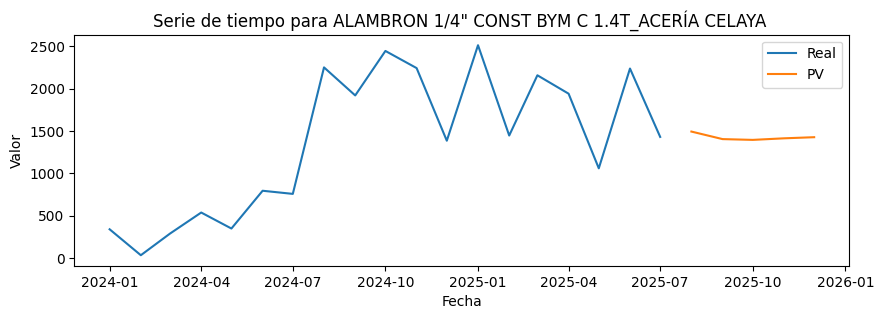

ALAMBRON 5.5MM 1004 2.9T_ACERÍA CELAYA 


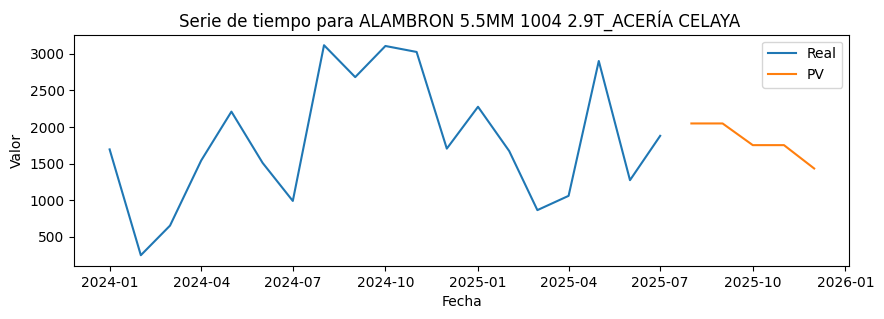

ALAMBRON 5.5MM 1004 2.9T_ACERÍA SALTILLO 


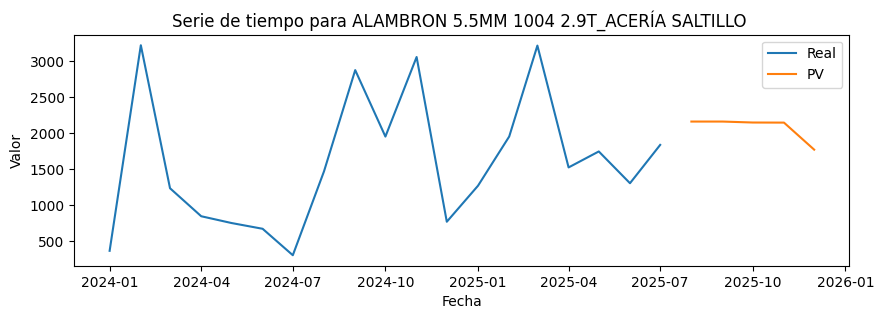

ALAMBRON 5.5MM 1004 M 2.5T_ACERÍA CELAYA 


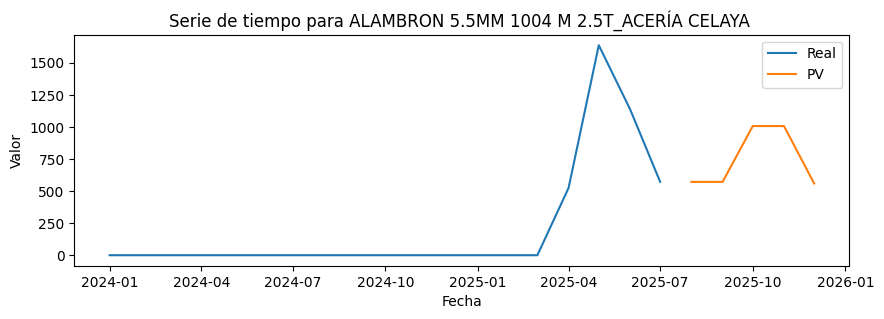

ALAMBRON 5.5MM 1006 SAE 2.5T_ACERÍA CELAYA 


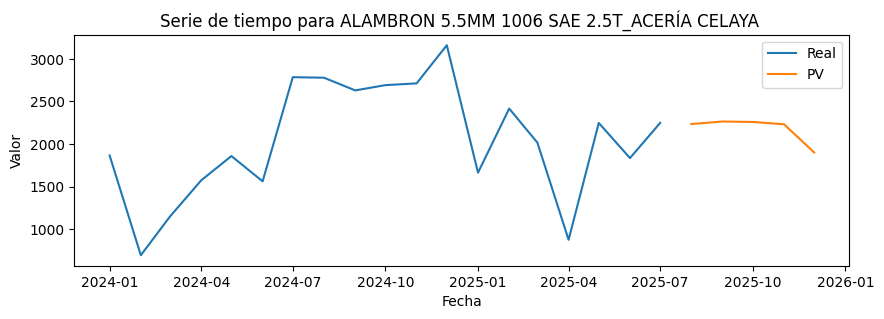

ALAMBRON 5.5MM BC COLLIS 1.4T_ACERÍA CELAYA 


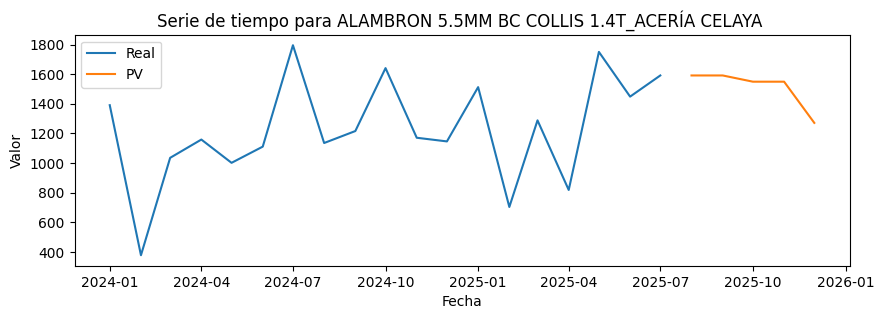

ALAMBRON 6.5MM 1006 VDE_ACERÍA SALTILLO 


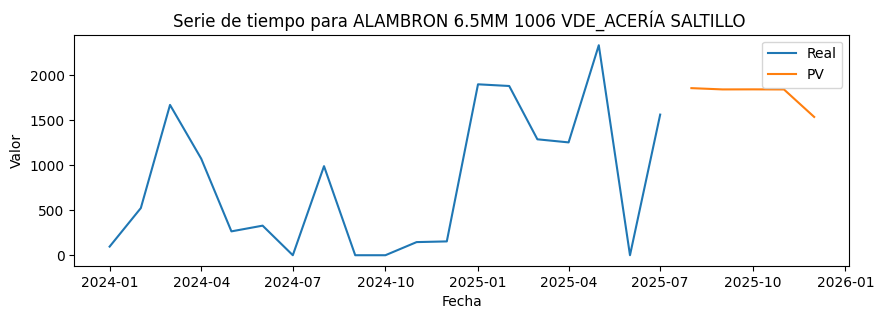

ALAMBRON 6.5MM 1015 VAR TURIA_3PL COATZACOALCOS 


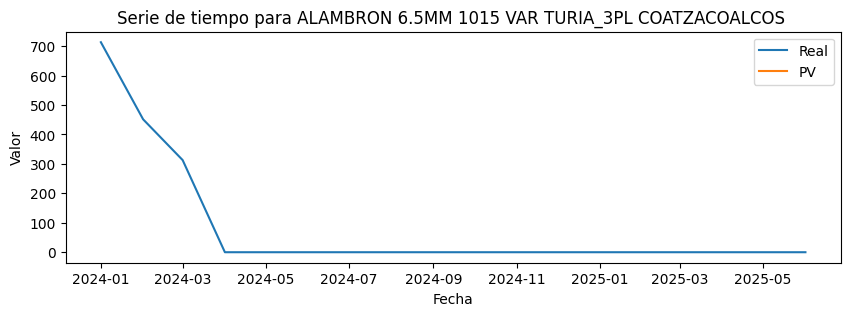

BARRA CORRUGADA DEACERO 615 G60 C2 3/8" 9.0M P23 R_PUERTO MAZATLAN 


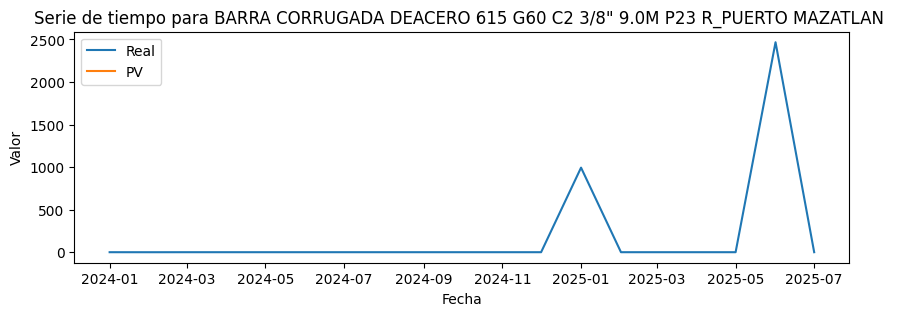

BILLET 180 1018-V 30FT_B. USA VTS DIR 


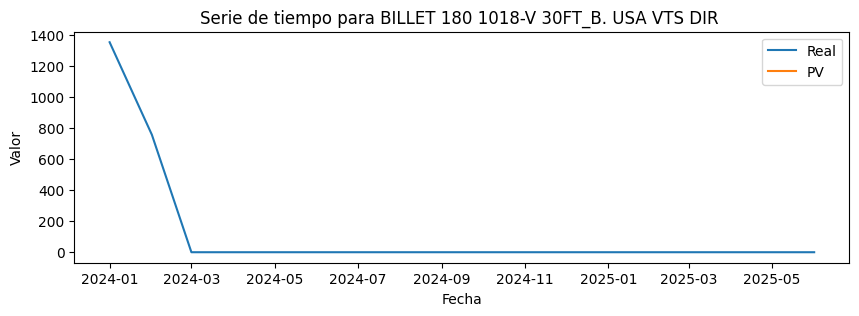

BILLET 180 1045-V 30FT_B. USA VTS DIR 


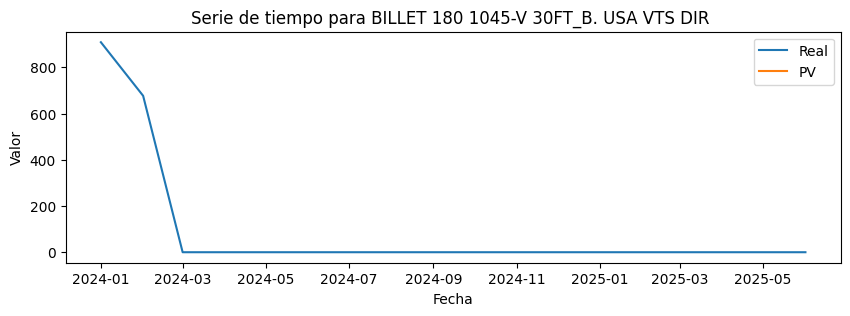

PALANQUILLA 130 1044 MITTAL 13.0 M_ACERÍA CELAYA 


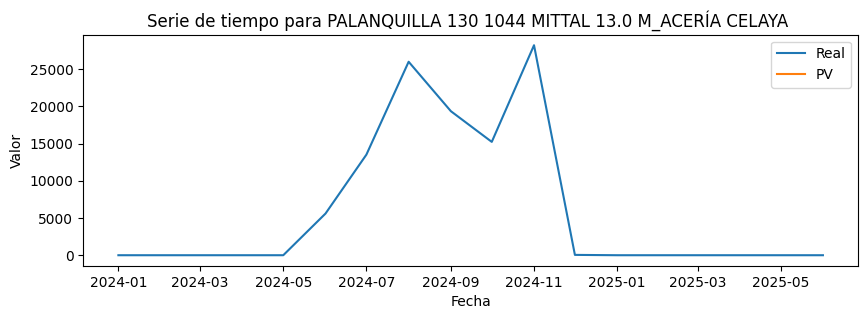

PALANQUILLA 130 G60 12.0 M_PUERTO MAZATLAN 


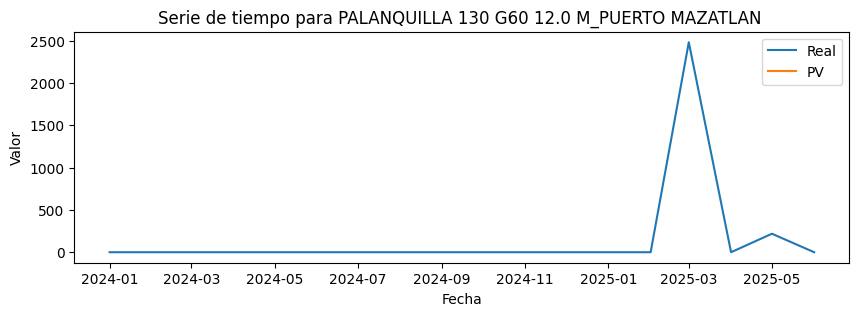

REBAR DA- 706 G60 C2 1/2" 20FT P02 R_B. USA VTS DIR 


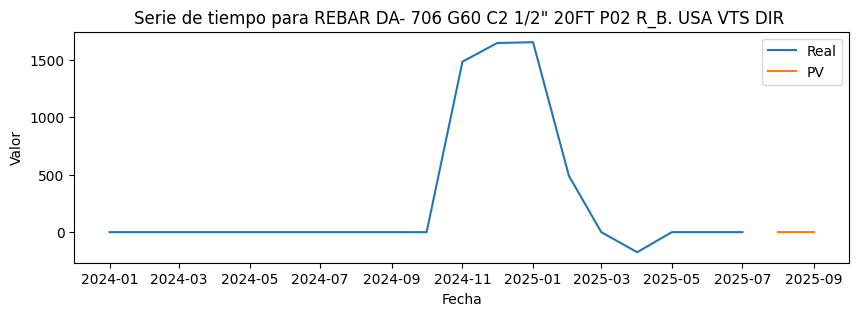

REBAR DA- 706 G60 C2 3/8" 20FT P08 R_B. USA VTS DIR 


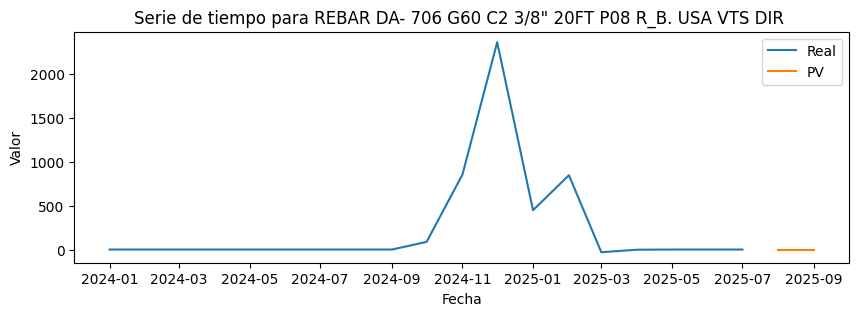

REBAR DA- 706 G60 C2 3/8" 20FT P08 R_CEDI HOUSTON-GULFSTR 


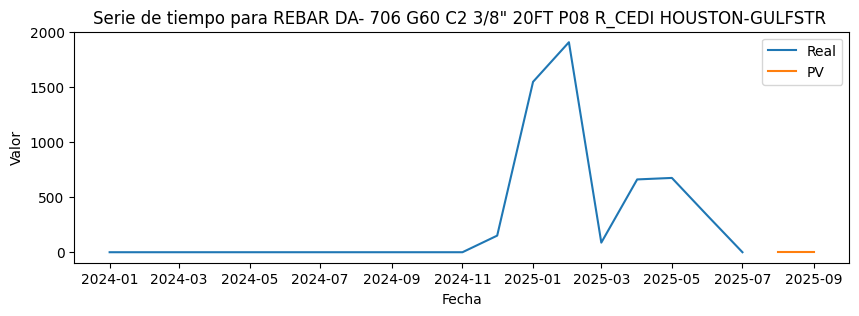

REBAR DA- 706 G60 C2 5/8" 20FT P09 R_B. USA VTS DIR 


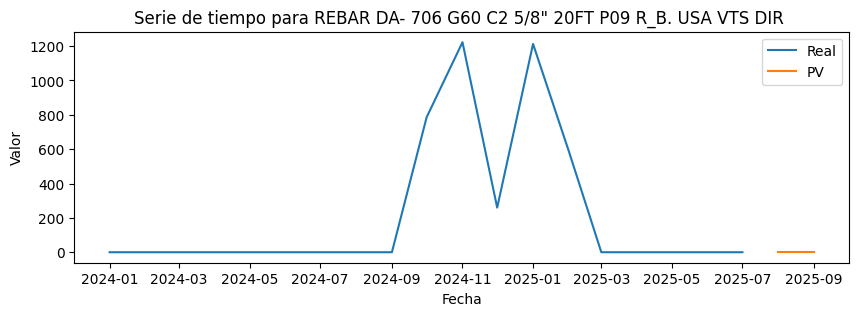

REBAR DA- CAN G400 W C2 10M 6.0 M P14 R_MACROHUB LAREDO 


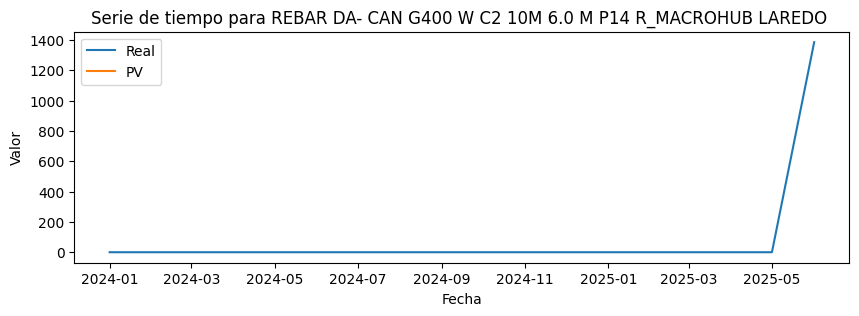

SOLAR PIERS 6" X 10.4 A992/572-65 126" ARRAY+DAMPER NO PAINT_B. INGETEK USA. 


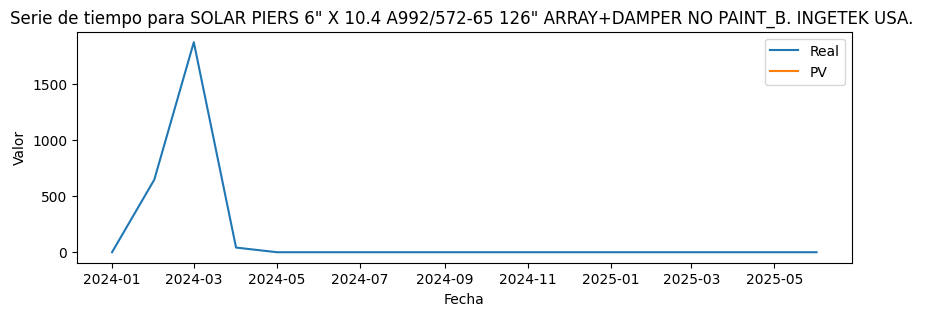

SOLAR PIERS 6" X 12.0 A572-65 153" ARRAY+DAMPER NO PAINT_B. INGETEK USA. 


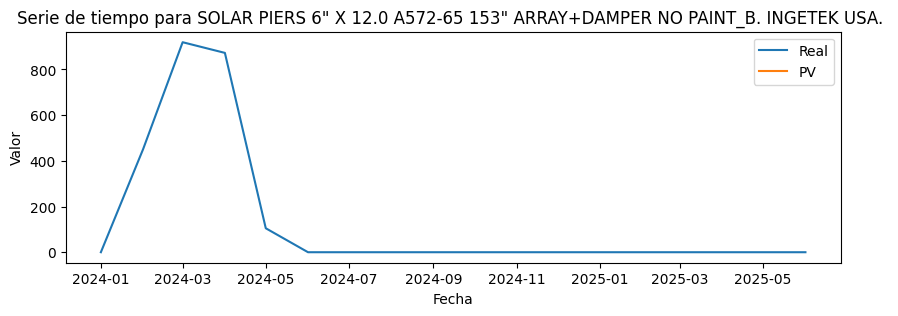

VARILLA DA- 506 G42 C1 1 1/4" 12.0 M P06 R_CEDI VIRTUAL ACERIA CELAYA INGETEK 


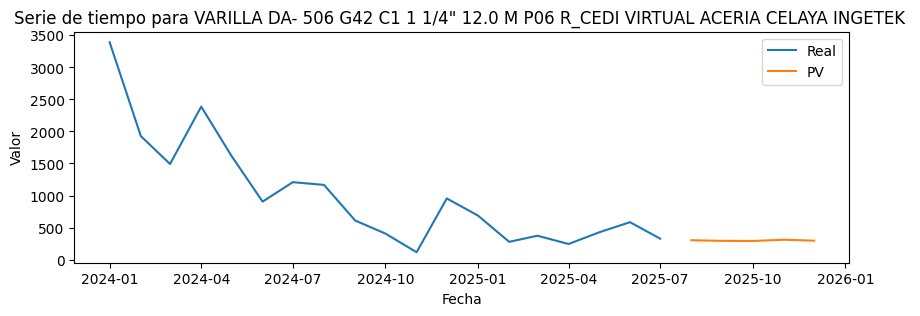

VARILLA DA- 506 G42 C1 1" 12.0 M P05 R_ACERÍA CELAYA 


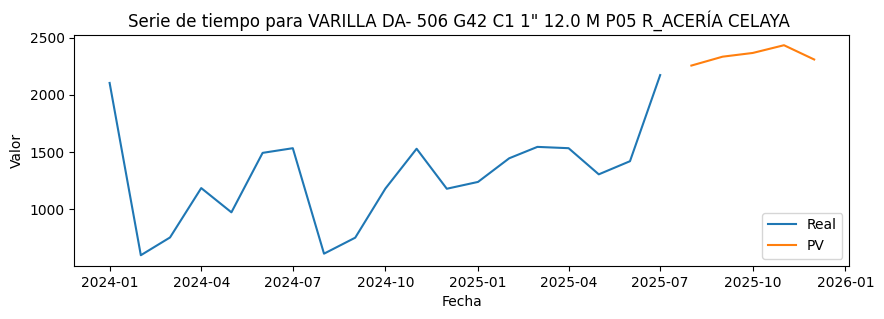

VARILLA DA- 506 G42 C1 1" 12.0 M P05 R_CEDI VIRTUAL ACERIA CELAYA INGETEK 


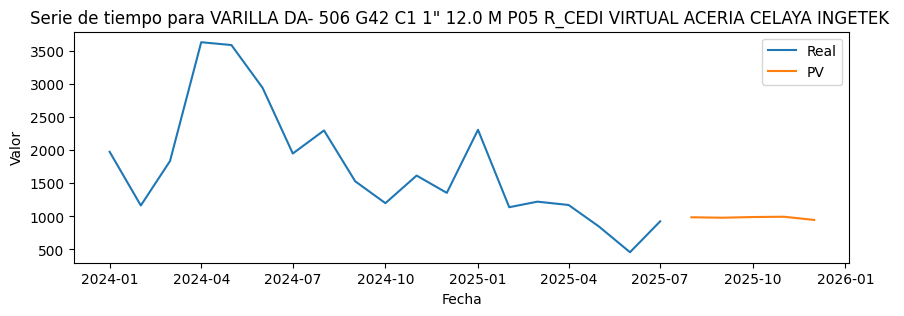

VARILLA DA- 506 G42 C1 1" 12.0 M P05 R_CEDI VIRTUAL MERIDA INGETEK 


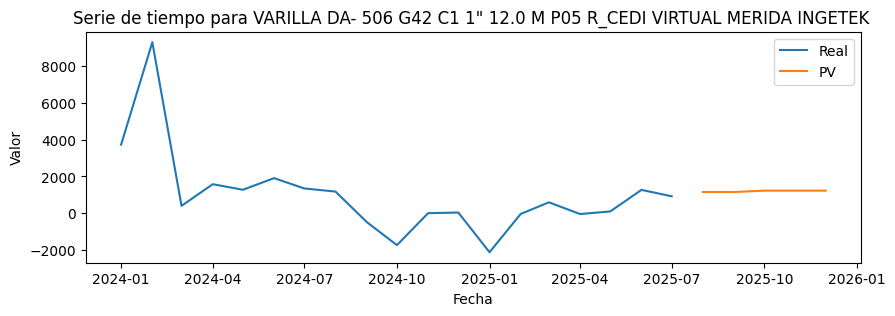

VARILLA DA- 506 G42 C1 1/2" 12.0 M P02 R_ACERÍA CELAYA 


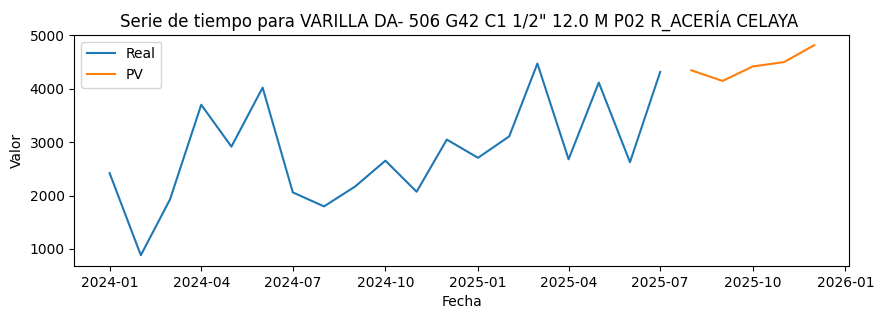

VARILLA DA- 506 G42 C1 1/2" 12.0 M P02 R_ACERÍA RAMOS ARIZPE 


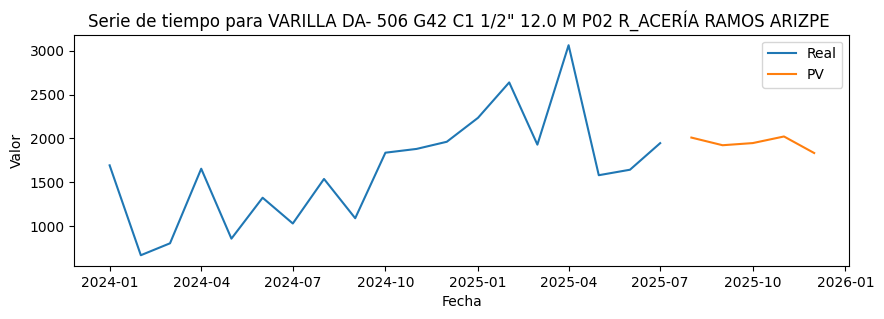

VARILLA DA- 506 G42 C1 1/2" 12.0 M P02 R_CEDI VIRTUAL ACERIA CELAYA INGETEK 


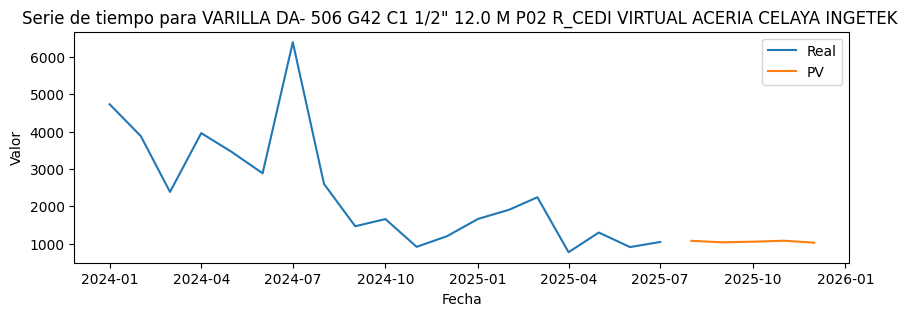

VARILLA DA- 506 G42 C1 3/4" 12.0 M P04 R_ACERÍA CELAYA 


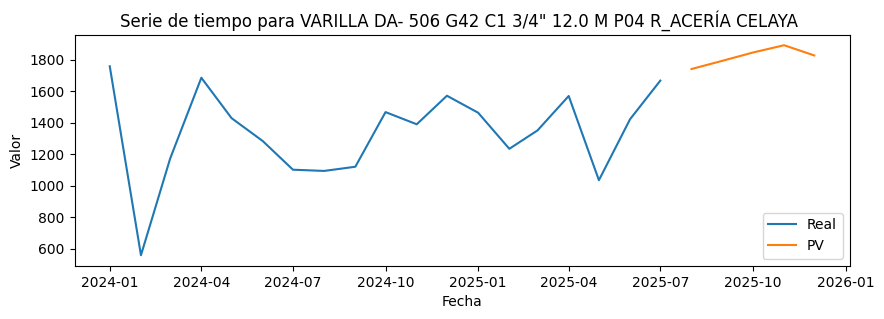

VARILLA DA- 506 G42 C1 3/4" 12.0 M P04 R_CEDI VIRTUAL ACERIA CELAYA INGETEK 


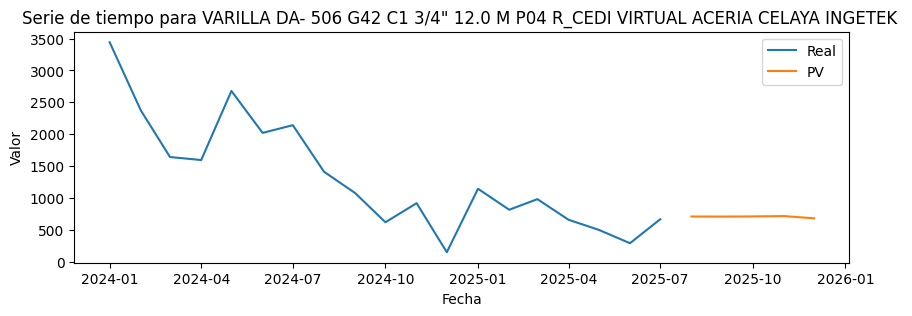

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 D_3PL COATZACOALCOS 


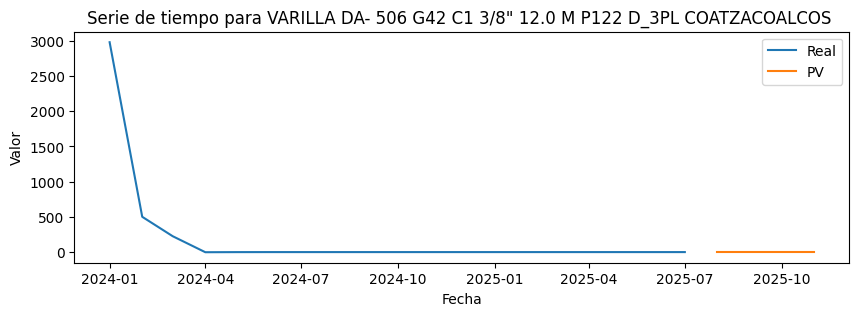

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 D_ACERÍA CELAYA 


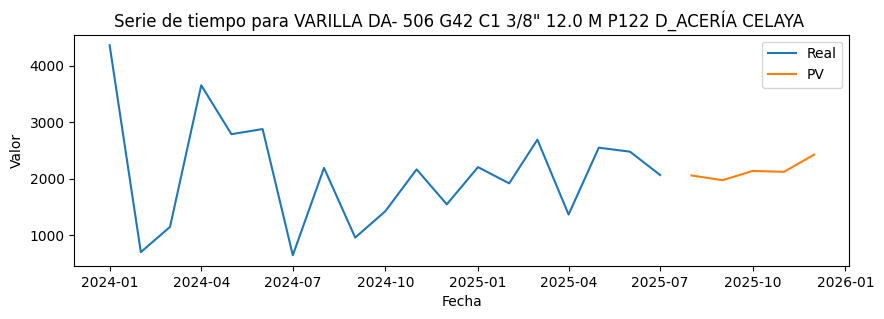

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 D_PATIO PUEBLA 


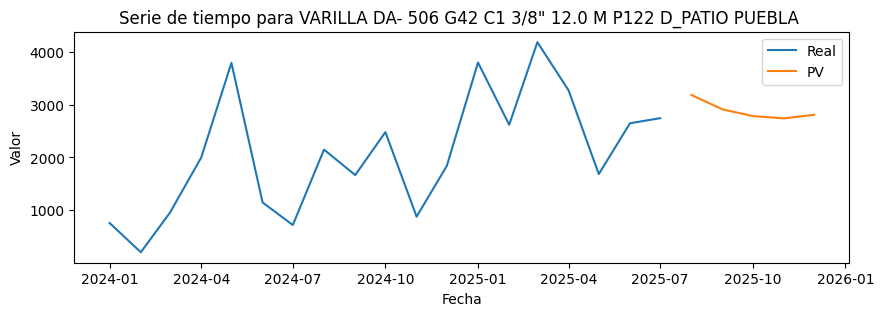

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 R_ACERÍA CELAYA 


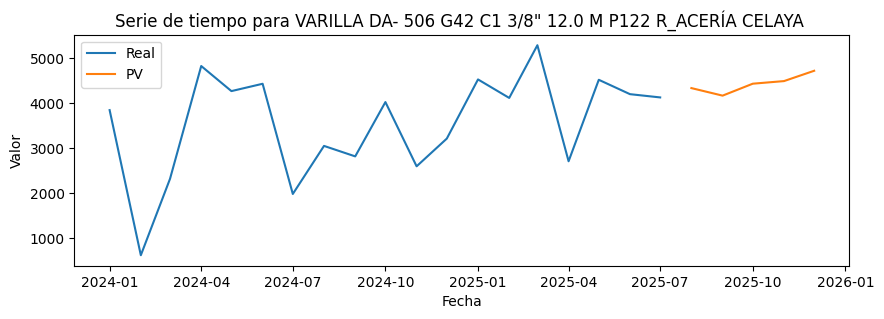

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 R_ACERÍA RAMOS ARIZPE 


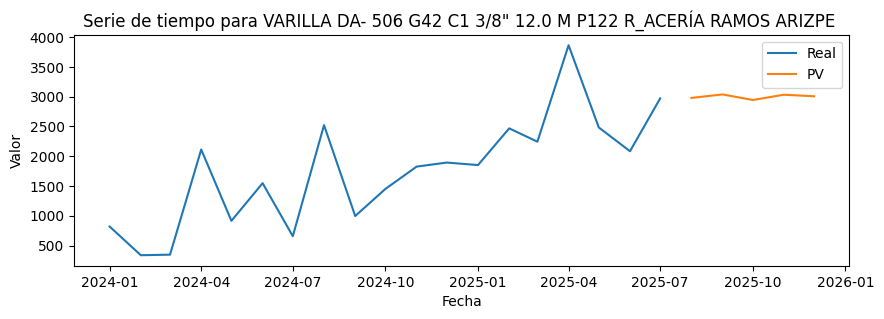

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 R_CEDI VIRTUAL ACERIA CELAYA INGETEK 


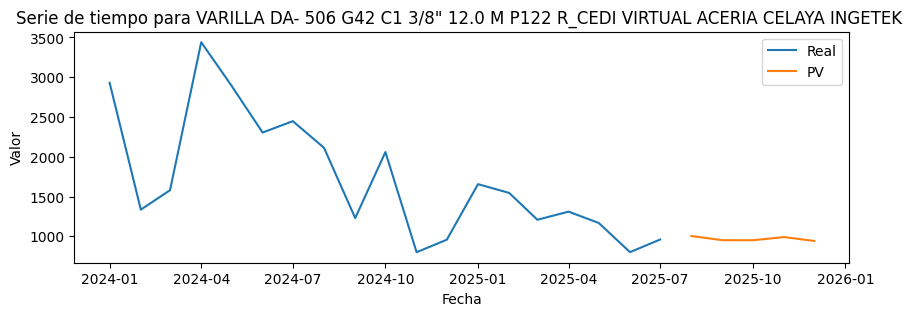

VARILLA DA- 506 G42 C1 3/8" 12.0 M P122 R_PATIO MERIDA 


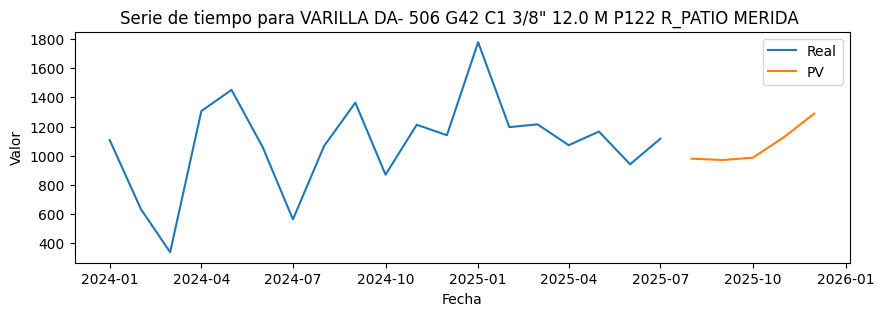

VARILLA DA- 506 G42 C1 5/8" 12.0 M P03 R_ACERÍA CELAYA 


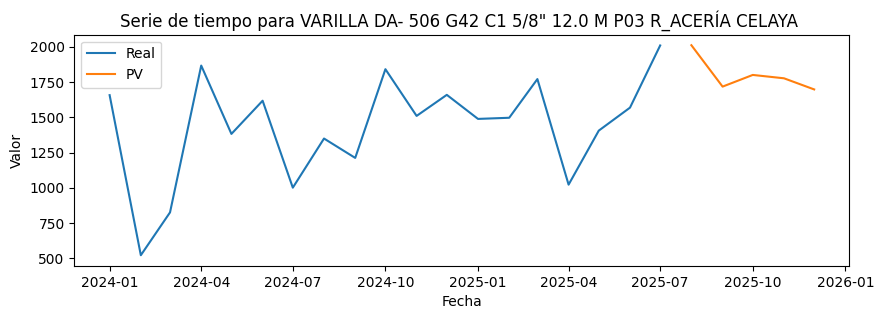

VARILLA DA- 506 G42 C1 5/8" 12.0 M P03 R_CEDI VIRTUAL ACERIA CELAYA INGETEK 


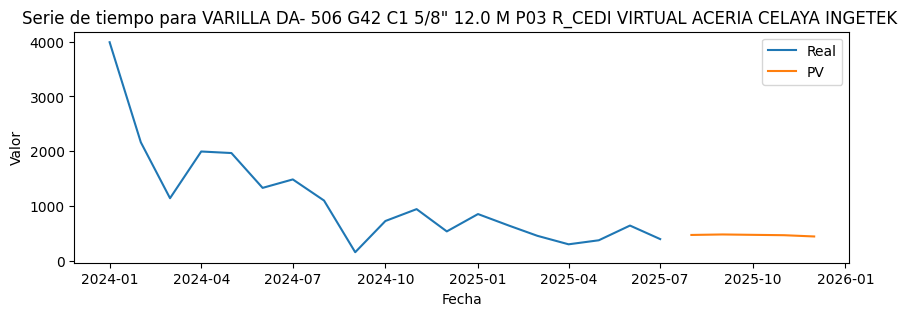

VARILLA DA- 506 G42 C1 5/8" 12.0 M P03 R_CEDI VIRTUAL MERIDA INGETEK 


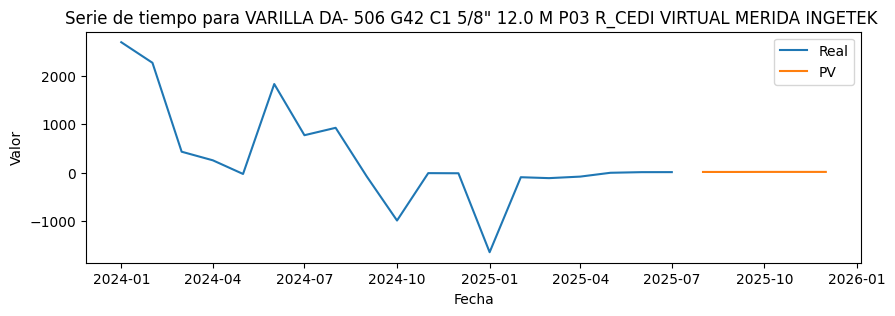

VARILLA DA- 506 G42 C5 1 1/4" 12.0 M P61 R INGETEK_CEDI VIRTUAL ACERIA CELAYA INGETEK 


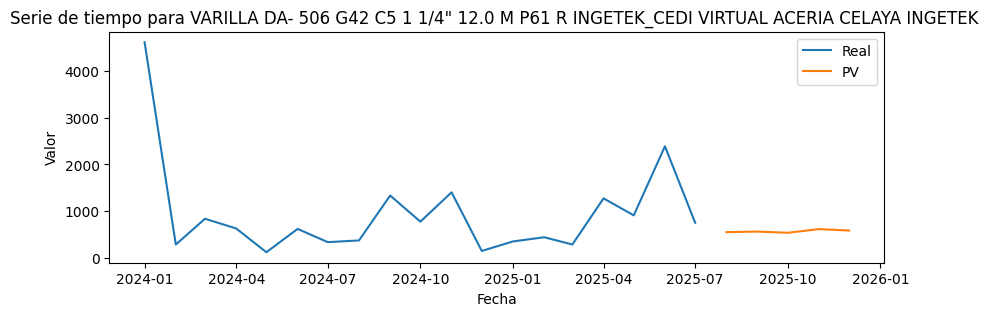

In [74]:
X_ = pd.melt(cluster_2.drop(columns = "tipo"), ignore_index= False).reset_index()
X_["tipo"] = np.where(X_.MesAnio > "2025-07-01","PV", "Real")
display(X_.head())

for i in X_.id.unique()[:40]:
    print(i)
    X_i = X_[X_.id == i]
    plt.figure(figsize=(10, 3))
    sns.lineplot(X_i, x = "MesAnio", y = "value", hue = "tipo")
    plt.title(f"Serie de tiempo para {i}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
